### UNSUPERVISED MACHINE LEARNING FOR THE CLASSIFICATION OF ASTROPHYSICAL X-RAY SOURCES

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min, silhouette_score
from sklearn.preprocessing import MinMaxScaler
from astropy import stats
from astropy.io.votable import parse

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
#plt.rcParams['figure.figsize'] = (16, 16)
#plt.style.use('ggplot')

In [2]:
def votable_to_pandas(votable_file):
    votable = parse(votable_file)
    table = votable.get_first_table().to_table(use_names_over_ids=True)
    return table.to_pandas()

In [3]:
data = votable_to_pandas("./data/corpus.vot")

#### Exploración

In [4]:
data.describe()

,obsid,region_id,theta,ra,dec,significance,likelihood,src_area_b,flux_aper_b,hard_hm,...,ks_prob_h,ks_prob_m,ks_prob_s,kp_prob_b,kp_prob_h,kp_prob_m,kp_prob_s,gti_start,gti_stop,gti_elapse
count,37878.000000,37878.000000,37878.000000,37878.000000,37878.000000,37878.000000,3.787800e+04,29752.000000,3.776100e+04,37344.000000,...,33730.000000,35920.000000,3.363000e+04,37420.000000,33730.000000,35920.000000,33630.000000,3.787800e+04,3.787800e+04,37878.000000
mean,7738.962062,383.943080,7.215788,154.484116,-1.713048,44.685588,inf,458.110004,7.113161e-13,0.064582,...,0.607855,0.594805,5.714102e-01,0.627788,0.603570,0.588157,0.565971,2.790502e+08,2.791110e+08,60807.276504
std,4442.685154,840.636764,5.359062,96.174054,38.778529,64.438054,inf,3167.216755,5.771520e-12,0.360548,...,0.318574,0.317466,3.140634e-01,0.325054,0.319590,0.318298,0.313054,1.260029e+08,1.259975e+08,47706.375641
min,19.000000,1.000000,0.004970,0.012318,-85.645638,0.000000,8.097478e+00,0.000037,0.000000e+00,-0.999375,...,0.000035,0.000008,2.968807e-07,0.000023,0.000023,0.000025,0.000002,6.561709e+07,6.566766e+07,948.465970
25%,4181.500000,25.000000,2.778966,83.763094,-29.053841,12.842973,5.664561e+02,0.394041,4.089393e-14,-0.119925,...,0.335645,0.320623,2.962773e-01,0.346806,0.328890,0.309782,0.295771,1.592887e+08,1.594554e+08,27452.799890
50%,7064.000000,96.000000,6.083105,160.982107,-5.355699,21.569519,1.903882e+03,5.090457,9.094241e-14,0.058713,...,0.647459,0.628799,5.966723e-01,0.680281,0.641305,0.623832,0.584503,2.778035e+08,2.778564e+08,48051.200045
75%,11530.000000,312.000000,11.240255,228.306555,33.975893,48.664213,1.084745e+04,55.606112,2.870870e-13,0.227358,...,0.918568,0.900790,8.652320e-01,0.956059,0.918414,0.891419,0.857505,3.852647e+08,3.853960e+08,88428.799680
max,49899.000000,7213.000000,26.922311,359.997656,86.320337,1181.210704,1.797693e+308,143596.278780,5.414790e-10,0.999375,...,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,5.361096e+08,5.361516e+08,192363.182400


In [5]:
data.head()

,name,obsid,region_id,theta,ra,dec,significance,likelihood,src_area_b,flux_aper_b,...,ks_prob_h,ks_prob_m,ks_prob_s,kp_prob_b,kp_prob_h,kp_prob_m,kp_prob_s,gti_start,gti_stop,gti_elapse
0,2CXO J000002.9-350332,15712,4,5.606038,0.012318,-35.059068,16.266113,1506.051665,6.228827,3.589425e-13,...,0.724755,0.317516,0.423297,0.808309,0.669796,0.197852,0.691868,4.989492e+08,4.989593e+08,10068.80008
1,2CXO J000010.0-501526,11997,5,7.662707,0.041803,-50.257400,16.952246,1018.200194,8.978497,3.593006e-14,...,0.249246,0.181138,0.805236,0.614278,0.101385,0.028956,0.918830,3.991763e+08,3.992403e+08,64051.80924
2,2CXO J000019.8-245030,13394,69,14.525021,0.082814,-24.841752,10.720911,351.465473,884.616067,1.002743e-13,...,0.847319,0.495847,0.506963,0.430789,0.817322,0.353208,0.778730,4.294139e+08,4.294639e+08,50055.70038
3,2CXO J000025.4-245419,13394,41,11.145001,0.106246,-24.905300,16.716272,819.212066,39.749528,1.160466e-13,...,0.067084,0.939628,0.368044,0.924866,0.051374,0.950423,0.288221,4.294139e+08,4.294639e+08,50055.70038
4,2CXO J000027.4-500421,11997,43,5.944960,0.114303,-50.072669,26.377284,3525.375052,3.925662,1.093804e-13,...,0.969048,0.227237,0.030124,0.766089,0.932166,0.556750,0.047099,3.991763e+08,3.992403e+08,64051.80924


In [6]:
data.columns

Index(['name', 'obsid', 'region_id', 'theta', 'ra', 'dec', 'significance',
       'likelihood', 'src_area_b', 'flux_aper_b', 'hard_hm', 'hard_hs',
       'hard_ms', 'powlaw_gamma', 'bb_kt', 'var_prob_b', 'var_sigma_b',
       'var_mean_b', 'var_min_b', 'var_max_b', 'var_prob_h', 'var_sigma_h',
       'var_mean_h', 'var_min_h', 'var_max_h', 'var_prob_m', 'var_sigma_m',
       'var_mean_m', 'var_min_m', 'var_max_m', 'var_prob_s', 'var_sigma_s',
       'var_mean_s', 'var_min_s', 'var_max_s', 'ks_prob_b', 'ks_prob_h',
       'ks_prob_m', 'ks_prob_s', 'kp_prob_b', 'kp_prob_h', 'kp_prob_m',
       'kp_prob_s', 'gti_start', 'gti_stop', 'gti_elapse'],
      dtype='object')

---
# K-Means

In [7]:
features_out = ['name', 'ra', 'dec', 'theta', 'src_area_b', 'flux_aper_b', 
                'hard_hm', 'hard_hs',
               'hard_ms', 'powlaw_gamma', 'bb_kt', 'var_prob_b', 'var_sigma_b',
               'var_mean_b', 'var_min_b', 'var_max_b', 'var_prob_h', 'var_sigma_h',
               'var_mean_h', 'var_min_h', 'var_max_h', 'var_prob_m', 'var_sigma_m',
               'var_mean_m', 'var_min_m', 'var_max_m', 'var_prob_s', 'var_sigma_s',
               'var_mean_s', 'var_min_s', 'var_max_s', 'ks_prob_b', 'ks_prob_h',
               'ks_prob_m', 'ks_prob_s', 'kp_prob_b', 'kp_prob_h', 'kp_prob_m',
               'kp_prob_s']

features = ['theta', 'src_area_b', 'flux_aper_b', 
            'hard_hm', 'hard_hs',
           'hard_ms', 'powlaw_gamma', 'bb_kt', 'var_prob_b', 'var_sigma_b',
           'var_mean_b', 'var_min_b', 'var_max_b', 'var_prob_h', 'var_sigma_h',
           'var_mean_h', 'var_min_h', 'var_max_h', 'var_prob_m', 'var_sigma_m',
           'var_mean_m', 'var_min_m', 'var_max_m', 'var_prob_s', 'var_sigma_s',
           'var_mean_s', 'var_min_s', 'var_max_s', 'ks_prob_b', 'ks_prob_h',
           'ks_prob_m', 'ks_prob_s', 'kp_prob_b', 'kp_prob_h', 'kp_prob_m',
           'kp_prob_s']

features_lognorm = ['theta', 'src_area_b', 'flux_aper_b', 'bb_kt', 'var_sigma_b',
           'var_mean_b', 'var_min_b', 'var_max_b', 'var_sigma_h',
           'var_mean_h', 'var_min_h', 'var_max_h', 'var_sigma_m',
           'var_mean_m', 'var_min_m', 'var_max_m',  'var_sigma_s',
           'var_mean_s', 'var_min_s', 'var_max_s']

features_norm = ['powlaw_gamma']

X_df_out = data[features_out].dropna()
X_df = X_df_out[features]
X = X_df.copy().to_numpy()


In [27]:
# WHITENING
# POR CORREGIR MATRIZ DE COVARIANZA
X_white = X_df.copy().to_numpy()
#X_white = (X_white - np.mean(X_white))*np.linalg.inv(np.cov(X_white))

LinAlgError: Singular matrix

## Applying log transform and normalizing.

In [9]:
# FUNCTION lognorm
# Apply log transform adding the minimum non-zero value divided by ten in order to preserve zero properties, then normalize.
# INPUT:
# X_df = data array
# X = data array as np array
# name_desc = string, name of the descriptor
# log = boolean, True if apply log transform before norm

# PROCEDURE:
# Modifies X np array of data with the normalizated data
def lognorm(X_df, X, name_desc, log):
    
    col = X_df.columns.get_loc(name_desc)
    X_desc = X_df[name_desc]
    
    if log:
        nonzero = X_desc[X_desc!=0]
        minval = np.min(nonzero)/10

        # print(minval)
        X_desc = X_desc + minval

        x = np.log(X_desc.values)  #returns a numpy array
    else:
        x = X_desc.to_numpy()
    min_max_scaler = MinMaxScaler(feature_range=(0,1))
    x_scaled = min_max_scaler.fit_transform(x.reshape(-1,1))
    X[:,col] = x_scaled.flatten()
    
    return X

In [10]:
# Log transformation

for feature in features_lognorm:
    X = lognorm(X_df, X, feature, True)
        
for feature in features_norm:
    X = lognorm(X_df, X, feature, False)
        
# WHITENING
for feature in features_lognorm:
    X_white = lognorm(X_df, X_white, feature, True)
        
for feature in features_norm:
    X_white = lognorm(X_df, X_white, feature, False)

theta
src_area_b
flux_aper_b
bb_kt
var_sigma_b
var_mean_b
var_min_b
var_max_b
var_sigma_h
var_mean_h
var_min_h
var_max_h
var_sigma_m
var_mean_m
var_min_m
var_max_m
var_sigma_s
var_mean_s
var_min_s
var_max_s


In [11]:
X_df = pd.DataFrame(X, columns=X_df.columns)
X_df = X_df.dropna()
X_df_out = X_df_out.dropna()
X = X_df.to_numpy()

In [12]:
X_white_df = pd.DataFrame(X_white, columns=X_df.columns)
X_white_df = X_white_df.dropna()
X_white = X_white_df.to_numpy()

## NOTA: Hacer tabla con clusters y mandar a Rafael

In [25]:
X_df.min()

theta            0.000000e+00
src_area_b       0.000000e+00
flux_aper_b      0.000000e+00
hard_hm         -9.993754e-01
hard_hs         -9.993754e-01
hard_ms         -8.956902e-01
powlaw_gamma     0.000000e+00
bb_kt            0.000000e+00
var_prob_b      3.341805e-234
var_sigma_b      0.000000e+00
var_mean_b       0.000000e+00
var_min_b        0.000000e+00
var_max_b        0.000000e+00
var_prob_h      3.921796e-170
var_sigma_h      0.000000e+00
var_mean_h       0.000000e+00
var_min_h        0.000000e+00
var_max_h        0.000000e+00
var_prob_m       3.146332e-59
var_sigma_m      0.000000e+00
var_mean_m       0.000000e+00
var_min_m        0.000000e+00
var_max_m        0.000000e+00
var_prob_s       5.603721e-85
var_sigma_s      0.000000e+00
var_mean_s       0.000000e+00
var_min_s        0.000000e+00
var_max_s        0.000000e+00
ks_prob_b        1.545962e-05
ks_prob_h        3.495976e-05
ks_prob_m        7.600951e-06
ks_prob_s        2.968807e-07
kp_prob_b        2.339507e-05
kp_prob_h 

In [14]:
kmeans = KMeans(n_clusters=6).fit(X_white_df)
# Getting the cluster centers
C = kmeans.cluster_centers_
print(C)

# Predicting the clusters
labels = kmeans.predict(X_white)

[[ 0.67384908  0.38461416 -0.00324157 -0.00324075 -0.00324975 -0.00325142
   0.45362093  0.16555626 -0.00321502  0.7164391   0.2426974   0.82790033
   0.18566929 -0.00320702  0.61619526  0.20265713  0.7553735   0.15631132
  -0.00321221  0.60056433  0.18003543  0.38416222  0.1254509  -0.00321382
   0.59124349  0.22179433  0.42039112  0.16363476 -0.00318695 -0.00318945
  -0.00319042 -0.00319251 -0.00318758 -0.00318989 -0.00319118 -0.00319314]
 [ 0.87693369  0.61312267 -0.00324157 -0.00323742 -0.00325144 -0.00325606
   0.42382047  0.17026915 -0.00322235  0.69914127  0.20234741  0.82079928
   0.15305828 -0.00321361  0.60835547  0.1973151   0.75577002  0.15039657
  -0.00321456  0.59559946  0.15768386  0.35338165  0.1104532  -0.00321221
   0.59091602  0.19690742  0.38489015  0.14824685 -0.00319225 -0.00319455
  -0.00319506 -0.00319664 -0.00319271 -0.00319526 -0.00319547 -0.0031972 ]
 [ 0.65201058  0.40225502 -0.00324157 -0.00322727 -0.00323507 -0.003247
   0.40144468  0.20574652 -0.00322534 

[Text(0.5, 0, 'src_area_b')]

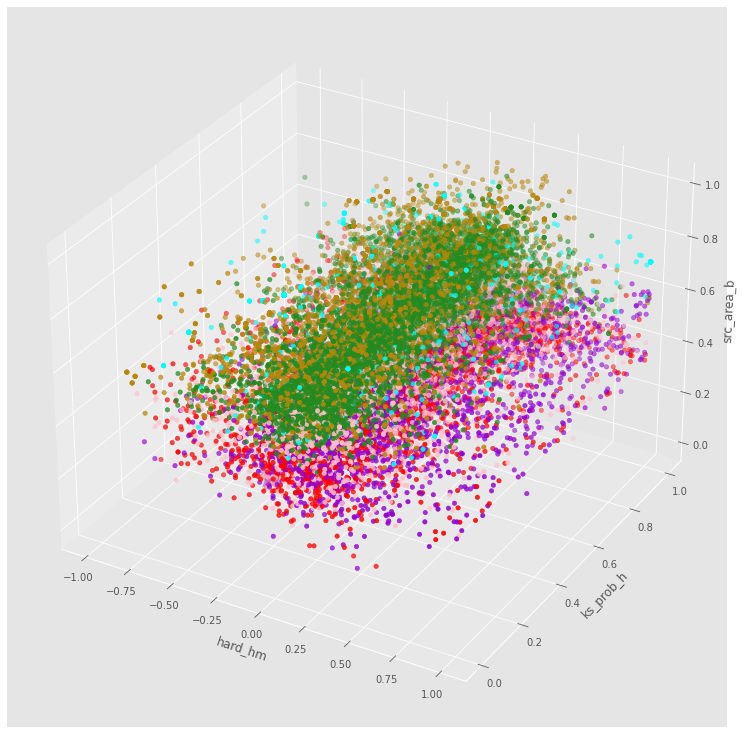

In [15]:
# %matplotlib notebook
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('ggplot')

colx = X_df.columns.get_loc("hard_hm")
coly = X_df.columns.get_loc("ks_prob_h")
colz = X_df.columns.get_loc("src_area_b")

#colores=['red','blue', 'green', 'k', 'forestgreen', 'darkviolet', 'darkgoldenrod', 'cyan', 'pink'] # 9
colores=['red', 'forestgreen', 'darkviolet', 'darkgoldenrod', 'cyan', 'pink'] # 6
#colores=['red', 'forestgreen', 'blue'] # 3
asignar=[]
for row in labels:
    asignar.append(colores[row])
    
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, colx], X[:, coly], X[:, colz], c=asignar,s=20)
ax.scatter(C[:, colx], C[:, coly], C[:, colz], marker='*', c=colores, s=1000)
ax.set(xlabel = X_df.columns[colx])
ax.set(ylabel = X_df.columns[coly])
ax.set(zlabel = X_df.columns[colz])

In [16]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('ggplot')

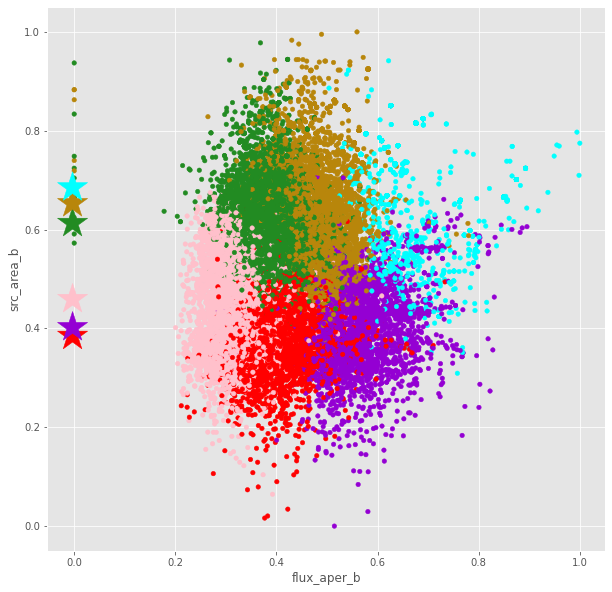

In [24]:
colx = X_df.columns.get_loc("flux_aper_b")
coly = X_df.columns.get_loc("src_area_b")
fig = plt.figure()
plt.scatter(X[:, colx], X[:, coly], c=asignar,s=20)
plt.scatter(C[:, colx], C[:, coly], marker='*', c=colores, s=1000)
plt.xlabel(X_df.columns[colx]);
plt.ylabel(X_df.columns[coly]);

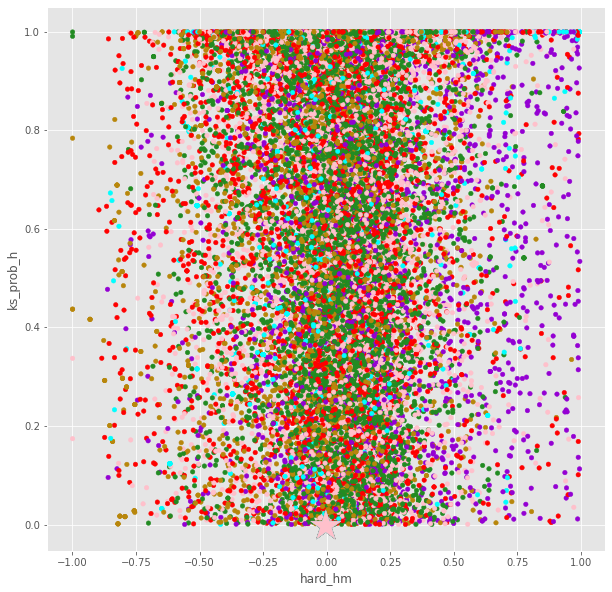

In [18]:
colx = X_df.columns.get_loc("hard_hm")
coly = X_df.columns.get_loc("ks_prob_h")
fig = plt.figure()
plt.scatter(X[:, colx], X[:, coly], c=asignar,s=20)
plt.scatter(C[:, colx], C[:, coly], marker='*', c=colores, s=1000)
plt.xlabel(X_df.columns[colx]);
plt.ylabel(X_df.columns[coly]);

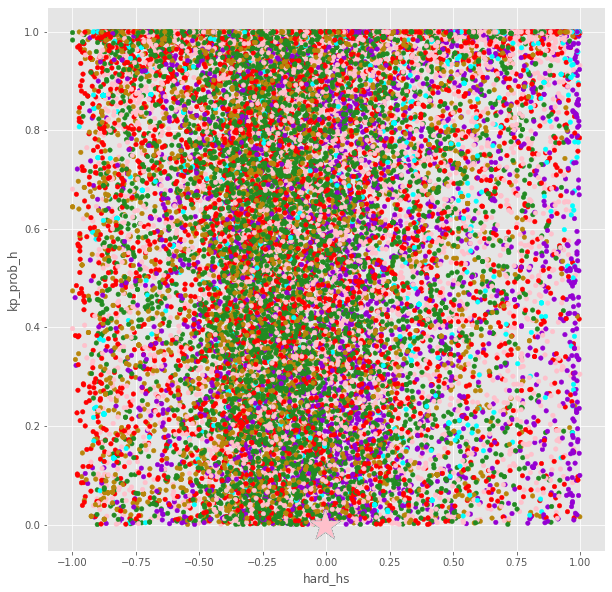

In [19]:
colx = X_df.columns.get_loc("hard_hs")
coly = X_df.columns.get_loc("kp_prob_h")
fig = plt.figure()
plt.scatter(X[:, colx], X[:, coly], c=asignar,s=20)
plt.scatter(C[:, colx], C[:, coly], marker='*', c=colores, s=1000)
plt.xlabel(X_df.columns[colx]);
plt.ylabel(X_df.columns[coly]);

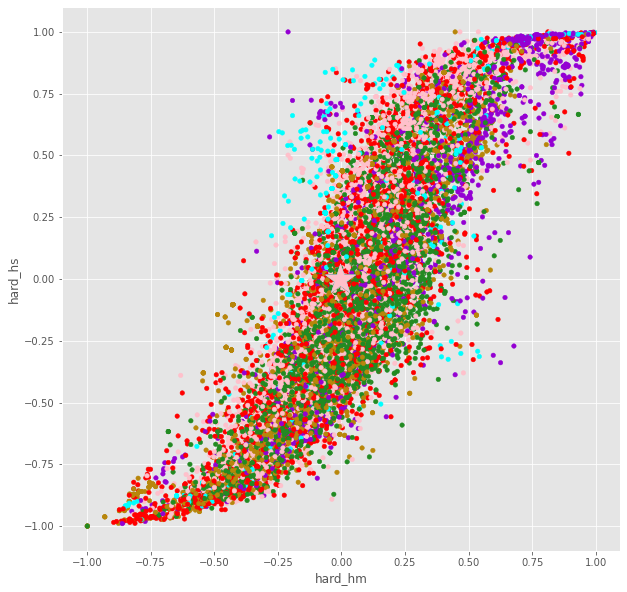

In [20]:
colx = X_df.columns.get_loc("hard_hm")
coly = X_df.columns.get_loc("hard_hs")
fig = plt.figure()
plt.scatter(X[:, colx], X[:, coly], c=asignar,s=20)
plt.scatter(C[:, colx], C[:, coly], marker='*', c=colores, s=1000)
plt.xlabel(X_df.columns[colx]);
plt.ylabel(X_df.columns[coly]);

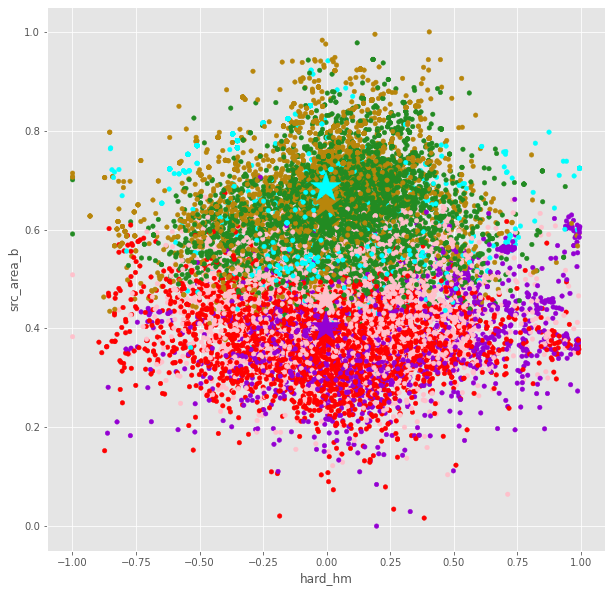

In [21]:
colx = X_df.columns.get_loc("hard_hm")
coly = X_df.columns.get_loc("src_area_b")
fig = plt.figure()
plt.scatter(X[:, colx], X[:, coly], c=asignar,s=20)
plt.scatter(C[:, colx], C[:, coly], marker='*', c=colores, s=1000)
plt.xlabel(X_df.columns[colx]);
plt.ylabel(X_df.columns[coly]);

In [22]:
X_df_out.insert(loc=0, column='cluster', value=labels)

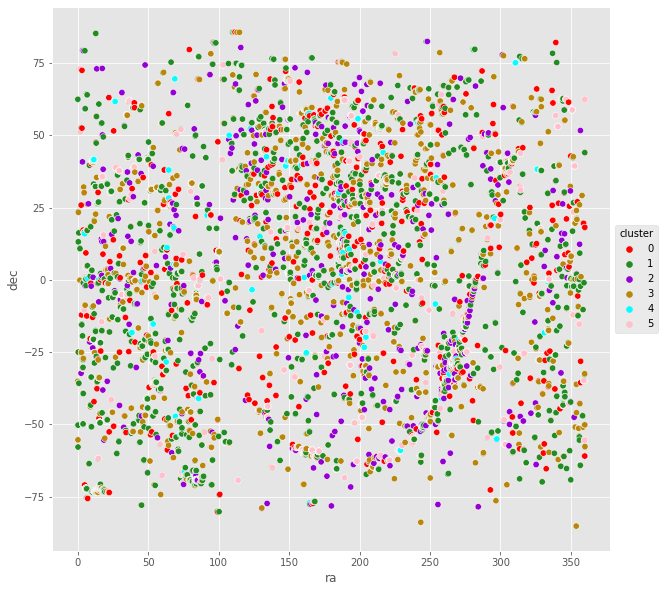

In [23]:
X_np_out=X_df_out.to_numpy()
colors = sns.color_palette()[0:6]

colx = X_df_out.columns.get_loc("ra")
coly = X_df_out.columns.get_loc("dec")
fig = plt.figure()
s = sns.scatterplot(data=X_df_out, x='ra', y='dec', hue=X_df_out["cluster"], palette=colores, s=40);
s.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, title='cluster')
plt.xlabel(X_df_out.columns[colx]);
plt.ylabel(X_df_out.columns[coly]);
plt.show()